# EDA the Full Catalog of Gaia DR3

In [1]:
# Basic Packages
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import gc

In [2]:
# PySpark packages
from pyspark import SparkContext   
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
sc = spark.sparkContext
sqlsc = SQLContext(sc)
sc.setCheckpointDir("hdfs://spark00:54310/tmp/checkpoints")
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark import Row
from pyspark.sql.window import Window as W
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

/usr/local/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


## Read all sky data 

In [3]:
import pyarrow as pa
import pyarrow.parquet as pq

In [4]:
filepath = "hdfs://spark00:54310/common/data/catalog/external-catalogs/parquet/gaia-dr3/raw/"

#### Read all parquets at once

In [5]:
%%time
rawdf = spark.read.option("header","true").option("recursiveFileLookup","true").parquet(filepath)

CPU times: user 1.7 ms, sys: 0 ns, total: 1.7 ms
Wall time: 3.55 s


In [6]:
print(rawdf.columns)

['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'parallax_over_error', 'pm', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr', 'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 'astrometric_excess_noise', 'astrometric_excess_noise_sig', 'astrometric_params_solved', 'astrometric_primary_flag', 'nu_eff_used_in_astrometry', 'pseudocolour', 'pseudocolour_error', 'ra_pseudocolour_corr', 'dec_pseudocolour_corr', 'parallax_pseudocolour_corr', 'pmra_pseudocolour_corr', 'pmdec_pseudocolour_corr', 'astrometric_matched_transits', 'visibility_periods_used', 'astrometric_sigma5d_max', 'matched_transits', 'new_matched_transits', 

## Select useful columns

In [7]:
df = rawdf.select('source_id','ra','dec','parallax','pm','pmra','pmdec', \
                  'astrometric_excess_noise','ruwe','classprob_dsc_combmod_quasar', \
                  'classprob_dsc_combmod_galaxy','classprob_dsc_combmod_star', \
                  'ra_error','dec_error','parallax_error','parallax_over_error','pmra_error','pmdec_error', \
                  'l','b','bp_rp','bp_g','g_rp')

In [8]:
df.cache()

DataFrame[source_id: bigint, ra: double, dec: double, parallax: double, pm: float, pmra: double, pmdec: double, astrometric_excess_noise: float, ruwe: float, classprob_dsc_combmod_quasar: float, classprob_dsc_combmod_galaxy: float, classprob_dsc_combmod_star: float, ra_error: float, dec_error: float, parallax_error: float, parallax_over_error: float, pmra_error: float, pmdec_error: float, l: double, b: double, bp_rp: float, bp_g: float, g_rp: float]

In [9]:
%%time
df.select('source_id','ra','dec','parallax').describe().toPandas().transpose()

CPU times: user 26.6 ms, sys: 8.31 ms, total: 34.9 ms
Wall time: 3min 11s


,0,1,2,3,4
summary,count,mean,stddev,min,max
source_id,1811709771,4.3515610592999383E18,1.64011514434601242E18,4295806720,6917528997577384320
ra,1811709771,229.12434364249683,77.78510767878035,3.4096239126626443E-7,359.999999939548
dec,1811709771,-18.374270531226507,36.53941026762342,-89.99287859590359,89.99005196682685
parallax,1467744818,0.36636113047677177,1.0261718025894748,-187.02939637423492,768.0665391873573


> **1.8 billion objects !** 

## Raw Stellar Objects

In [10]:
%%time
rawstardf = df.filter((F.col('classprob_dsc_combmod_star') > 0.5) & (F.col('ruwe') < 1.4))

CPU times: user 385 µs, sys: 585 µs, total: 970 µs
Wall time: 13.7 ms


In [11]:
rawstardf.select('source_id','ra','dec').describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
source_id,1304979431,4.3132475589375764E18,1.72159960843961216E18,4295806720,6917528997577384320
ra,1304979431,224.78295306096845,81.18003284199811,3.4096239126626443E-7,359.999999939548
dec,1304979431,-16.595830099101693,38.30390216592702,-89.99287859590359,89.99005196682685


> **1.3 billion stars !**

## HealPix Visualization: healpy: https://healpy.readthedocs.io/en/latest/tutorial.html 

#### Basic Settings for HealPix

In [12]:
import healpy as hp
NSIDE = 512
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

3145728


#### UDF for getting HealPix indices 

In [13]:
import numpy as np
import healpy as hp
def getHealPixIndexLatLon(inlat, inlon, nside):
    lat_theta = 0.5*np.pi - np.radians(inlat)
    lon_phi = np.radians(inlon)    
    return int(hp.ang2pix(nside,theta = lat_theta,phi= lon_phi,nest=True))

In [14]:
from functools import partial
healpixudf = F.udf(partial(getHealPixIndexLatLon,nside=NSIDE),T.IntegerType())

#### Applying the healpix 512 nested to all `rawstardf`

In [15]:
%%time
rawstardf = rawstardf.withColumn('ipx512nested',healpixudf(F.col('dec'),F.col('ra')))

CPU times: user 1.35 ms, sys: 1.74 ms, total: 3.09 ms
Wall time: 16.8 ms


In [16]:
rawstardf.cache()

DataFrame[source_id: bigint, ra: double, dec: double, parallax: double, pm: float, pmra: double, pmdec: double, astrometric_excess_noise: float, ruwe: float, classprob_dsc_combmod_quasar: float, classprob_dsc_combmod_galaxy: float, classprob_dsc_combmod_star: float, ra_error: float, dec_error: float, parallax_error: float, parallax_over_error: float, pmra_error: float, pmdec_error: float, l: double, b: double, bp_rp: float, bp_g: float, g_rp: float, ipx512nested: int]

In [17]:
rawstardf['source_id','ra','dec','ipx512nested'].limit(3).toPandas().transpose()

,0,1,2
source_id,9.002801e+16,9.002808e+16,9.002812e+16
ra,3.901629e+01,3.901472e+01,3.902991e+01
dec,2.397660e+01,2.399546e+01,2.399911e+01
ipx512nested,4.094000e+04,4.094000e+04,4.094000e+04


#### Groupby `ipx512nested` and count the stars in each `ipx512nested` group 

In [18]:
rawstarcountdf = rawstardf.groupBy('ipx512nested').agg(F.count("*").alias("count"))

#### Filling the missing groups with `zero`

In [19]:
%%time
repdf = rawstarcountdf.orderBy('ipx512nested').toPandas().set_index('ipx512nested')

CPU times: user 89.9 ms, sys: 85.4 ms, total: 175 ms
Wall time: 3.66 s


In [20]:
full_index = pd.RangeIndex(start=0, stop=NPIX)
filledpdf = repdf.reindex(full_index, fill_value=0)

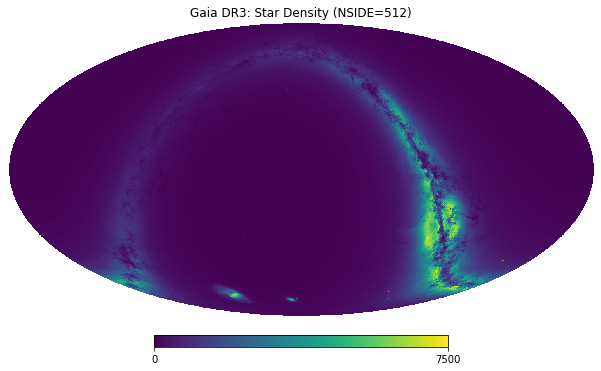

In [21]:
hp.mollview(filledpdf['count'].values,nest=True,title='Gaia DR3: Star Density (NSIDE=512)',xsize=2000)

### Galactic Coordinates

#### Adding healpix ids for galactic coordinates

In [22]:
rawstardf = rawstardf.withColumn('gal_ipx512nested',healpixudf(F.col('b'),F.col('l')))

In [23]:
rawstardf.cache()

DataFrame[source_id: bigint, ra: double, dec: double, parallax: double, pm: float, pmra: double, pmdec: double, astrometric_excess_noise: float, ruwe: float, classprob_dsc_combmod_quasar: float, classprob_dsc_combmod_galaxy: float, classprob_dsc_combmod_star: float, ra_error: float, dec_error: float, parallax_error: float, parallax_over_error: float, pmra_error: float, pmdec_error: float, l: double, b: double, bp_rp: float, bp_g: float, g_rp: float, ipx512nested: int, gal_ipx512nested: int]

#### Write the reduced `rawstardf` as a parquet in hdfs 

In [24]:
outfilename = \
"hdfs://spark00:54310/common/data/catalog/external-catalogs/parquet/gaia-dr3/reduced/rawstar.parquet.snappy"

In [25]:
%%time
rawstardf.write.option("compression", "snappy").mode("overwrite").save(outfilename)

CPU times: user 228 ms, sys: 208 ms, total: 435 ms
Wall time: 9min 47s


#### Visualizing in Galactic Coordinates

In [26]:
galrawstarcountdf = rawstardf.groupBy('gal_ipx512nested').agg(F.count("*").alias("count"))

In [27]:
full_index = pd.RangeIndex(start=0, stop=NPIX)

In [28]:
%%time
tmppdf = \
galrawstarcountdf.orderBy('gal_ipx512nested').toPandas()\
.set_index('gal_ipx512nested').reindex(full_index, fill_value=0)

CPU times: user 137 ms, sys: 97.2 ms, total: 234 ms
Wall time: 2.97 s


> The running time for `galcoordfastudf` is `12min`, while `galcoordudf` `6hours`

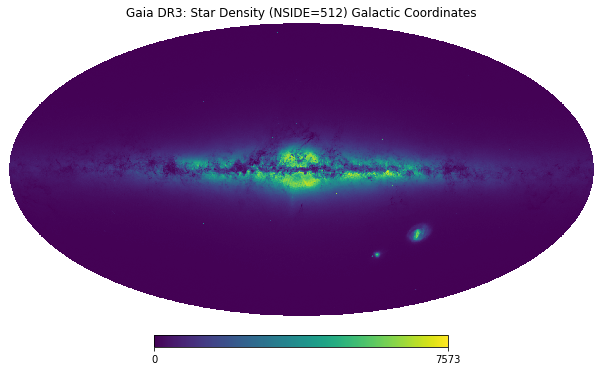

In [29]:
hp.mollview(tmppdf['count'].values,nest=True, \
            title='Gaia DR3: Star Density (NSIDE=512) Galactic Coordinates',xsize=2000)